In [4]:
# pip install split-folders

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/Dataset/without_mask/2664.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2539.png
/kaggle/input/face-mask-detection/Dataset/without_mask/1231.png
/kaggle/input/face-mask-detection/Dataset/without_mask/1017.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2437.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2015.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2300.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2673.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2823.png
/kaggle/input/face-mask-detection/Dataset/without_mask/1522.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2064.png
/kaggle/input/face-mask-detection/Dataset/without_mask/641.png
/kaggle/input/face-mask-detection/Dataset/without_mask/1088.png
/kaggle/input/face-mask-detection/Dataset/without_mask/173.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2851.png
/kaggle/input/face-mask-detection/Dataset/

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D,GlobalAveragePooling2D, Input, BatchNormalization
from keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
import splitfolders
path = "/kaggle/input/face-mask-detection/Dataset"

splitfolders.ratio(input = path, output="output", seed=1337, ratio=(0.8, 0.1, 0.1), group_prefix=None, move=False)

ModuleNotFoundError: No module named 'splitfolders'

In [ ]:
classes = os.listdir(path)
classes

In [9]:
train_path='/kaggle/working/output/train'
validation_path='/kaggle/working/output/val'
test_path='/kaggle/working/output/test'

data_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    )


In [12]:
train_ds = data_generator.flow_from_directory(train_path,
                                            color_mode = 'rgb',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            shuffle=True,
                                            class_mode = 'categorical',
                                            classes = classes)
val_ds = data_generator.flow_from_directory(validation_path,
                                            color_mode = 'rgb',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            shuffle=True,
                                            class_mode = 'categorical',
                                            classes = classes)

test_ds = data_generator.flow_from_directory(test_path,
                                            color_mode = 'rgb',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode = 'categorical',
                                            classes = classes,
                                            shuffle=True)

Found 7185 images belonging to 3 classes.
Found 897 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


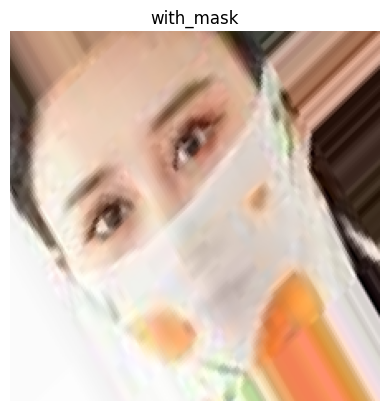

In [13]:
#ploting images
for img, label in train_ds:
    plt.imshow(img[0])
    index = label[0].argmax()
    plt.title(f"{classes[index]}")
    plt.axis('off')
    break

In [14]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANELS = 3

base_model = VGG16(input_shape = (IMG_WIDTH,IMG_HEIGHT,CHANELS),
                  include_top= False)


In [15]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
base_model.trainable = True

In [17]:
set_trainable = False

for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [19]:
inputImg = Input(shape = (IMG_HEIGHT,IMG_WIDTH,CHANELS), name= 'input')
base = base_model(inputImg)
x = Flatten()(base)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
# x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

output = Dense(len(classes),activation = 'softmax')(x)

model = Model(inputImg, output)

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,766,467 (456.87 MB)

 Trainable params: 112,122,755 (427.71 MB)

 Non-trainable params: 7,643,712 (29.16 MB)

In [41]:
# early stopping to prevent the overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True)

# model check point
model_check = ModelCheckpoint("best_model.keras", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [46]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy","precision","recall"])

In [48]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping, model_check])

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.6839 - loss: 0.7410 - precision: 0.7130 - recall: 0.6242
Epoch 1: val_accuracy improved from -inf to 0.90078, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 129s 522ms/step - accuracy: 0.6844 - loss: 0.7400 - precision: 0.7135 - recall: 0.6248 - val_accuracy: 0.9008 - val_loss: 0.2433 - val_precision: 0.9131 - val_recall: 0.8907
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8934 - loss: 0.3066 - precision: 0.9078 - recall: 0.8782
Epoch 2: val_accuracy did not improve from 0.90078
225/225 ━━━━━━━━━━━━━━━━━━━━ 93s 402ms/step - accuracy: 0.8935 - loss: 0.3065 - precision: 0.9079 - recall: 0.8782 - val_accuracy: 0.8506 - val_loss: 0.5118 - val_precision: 0.8573 - val_recall: 0.8439
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9151 - loss: 0.2433 - precision: 0.9233 - recall: 0.9039
Epoch 3: val_accuracy improved from 0.90078 to 0.92754, saving model to best_model.

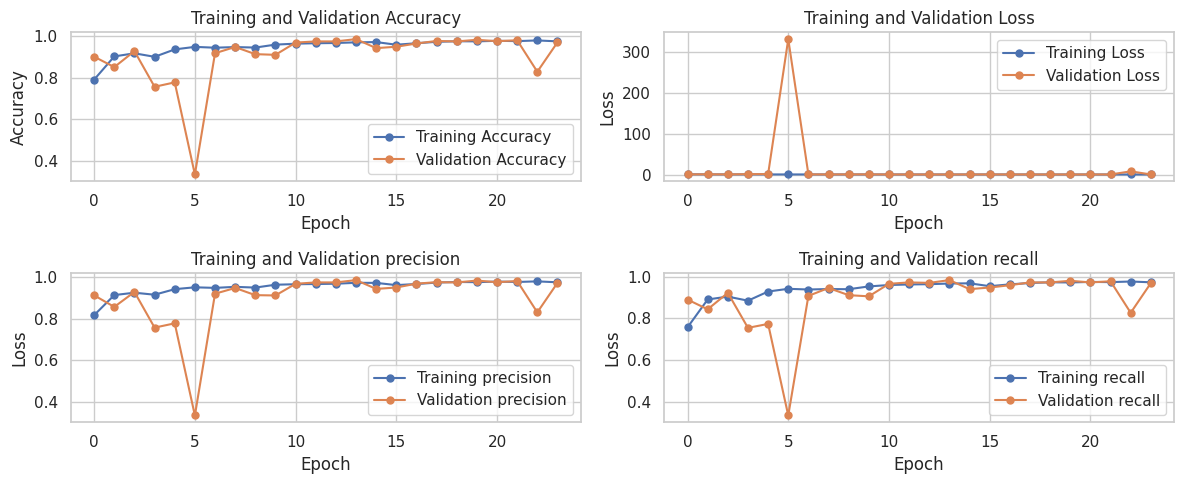

In [50]:
# The style
sns.set(style='whitegrid')

# Plotting training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o', markersize=5)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='-', marker='o', markersize=5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linestyle='-', marker='o', markersize=5)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='-', marker='o', markersize=5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Training precision', linestyle='-', marker='o', markersize=5)
plt.plot(history.history['val_precision'], label='Validation precision', linestyle='-', marker='o', markersize=5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Training recall', linestyle='-', marker='o', markersize=5)
plt.plot(history.history['val_recall'], label='Validation recall', linestyle='-', marker='o', markersize=5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation recall')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
model.save("vgg16\main_model.h5")
model.save_weights("vgg16\main_model.weights.h5")

In [52]:
loaded_model = load_model('best_model.keras')

In [54]:
loaded_model_vgg = load_model('vgg16\main_model.h5')

In [36]:
loaded_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,766,467 (456.87 MB)

 Trainable params: 112,122,755 (427.71 MB)

 Non-trainable params: 7,643,712 (29.16 MB)

In [56]:
#prediction
y_pred_bestModel = loaded_model.predict(test_ds)
y_pred_bestModel = y_pred_bestModel.argmax(axis = 1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step


In [57]:
y_pred_vgg = loaded_model_vgg.predict(test_ds)
y_pred_vgg = y_pred_vgg.argmax(axis = 1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step


In [58]:
y_pred_bestModel.shape

(900,)

In [59]:
y_pred_vgg.shape

(900,)

In [60]:
y_test = test_ds.classes

In [61]:
y_test.shape

(900,)

In [62]:
print("Classification report of best model")
print("=="*20)
print(classification_report(y_test, y_pred_bestModel))

Classification report of best model
              precision    recall  f1-score   support

           0       0.35      0.34      0.35       300
           1       0.36      0.37      0.36       300
           2       0.38      0.37      0.38       300

    accuracy                           0.36       900
   macro avg       0.36      0.36      0.36       900
weighted avg       0.36      0.36      0.36       900



In [63]:
print("Classification report of last saved model")
print("=="*20)
print(classification_report(y_test, y_pred_vgg))

Classification report of last saved model
              precision    recall  f1-score   support

           0       0.34      0.34      0.34       300
           1       0.31      0.31      0.31       300
           2       0.33      0.33      0.33       300

    accuracy                           0.33       900
   macro avg       0.33      0.33      0.33       900
weighted avg       0.33      0.33      0.33       900



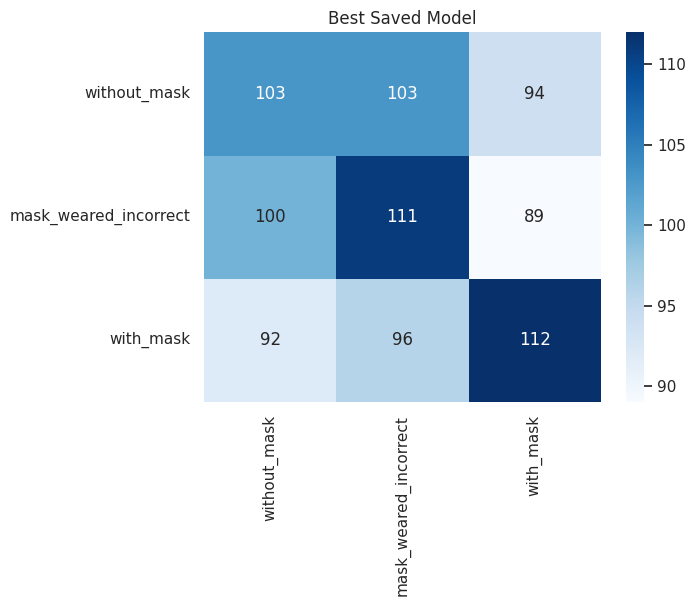

In [64]:
sns.heatmap(confusion_matrix(y_test, y_pred_bestModel),
           annot = True, fmt = '.0f',
           cmap = 'Blues',
           xticklabels=classes,
           yticklabels=classes)
plt.title("Best Saved Model")
plt.show()

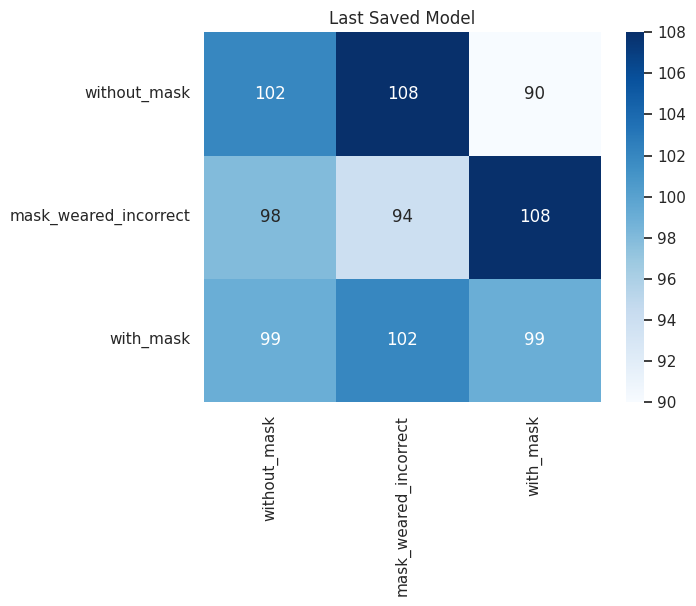

In [65]:
sns.heatmap(confusion_matrix(y_test, y_pred_vgg),
           annot = True, fmt = '.0f',
           cmap = 'Blues',
           xticklabels=classes,
           yticklabels=classes)
plt.title("Last Saved Model")
plt.show()

In [67]:
!zip -r file.zip /kaggle/working/best_model.keras

  adding: kaggle/working/best_model.keras (deflated 31%)


In [68]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

## Inferance

In [69]:
img_test = r"/kaggle/working/output/train/mask_weared_incorrect/2104.png"

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model



def prediction(path, model):
    # Load the image
    img = cv2.imread(path)
    if img is None:
        print("Error loading image.")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    # Detect faces in the image using a pre-trained Haar cascade model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    
    # Loop through the detected faces
    for (x, y, w, h) in faces:
        # Draw a green square around the face
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # Extract the face region
        face_region = img_rgb[y:y + h, x:x + w]
        face_region = cv2.resize(face_region, (224, 224))
        face_region = face_region / 255.0
        
        # Make predictions on the face region
        predictions = model.predict(np.expand_dims(face_region, axis=0))
        
        # Get the predicted label
        predicted_label = np.argmax(predictions)
        
        # Display the predicted label next to the green square
        cv2.putText(img_rgb, str(classes[predicted_label]), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Display the output image using matplotlib
    plt.imshow(img_rgb)
    plt.title('Output')
    plt.axis('off')
    plt.show()


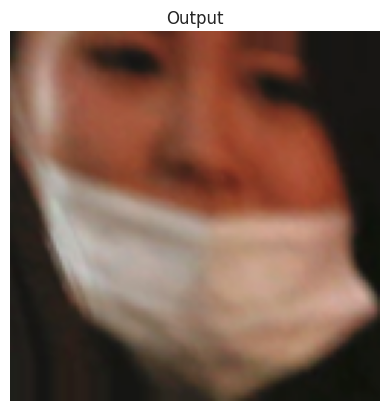

In [78]:
prediction(img_test, loaded_model)

## Inferance

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model


UnboundLocalError: local variable 'predicted_label' referenced before assignment

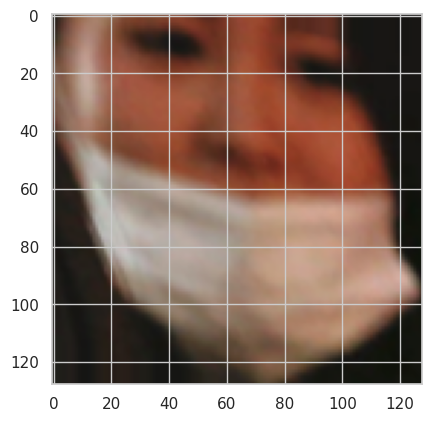

In [92]:
prediction(img_test, loaded_model)